# Feature transformation

In [30]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
from scipy.stats import boxcox

In [54]:
df = pd.read_csv('data/split/train.csv', encoding='latin1', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18296 entries, 0 to 18295
Data columns (total 51 columns):
average_pledge                           18296 non-null float64
backers_count                            18296 non-null int64
category_name                            18296 non-null object
category_parent                          18296 non-null object
category_position                        18296 non-null int64
country                                  18296 non-null object
currency                                 18296 non-null object
days_duration                            18296 non-null int64
days_preparation                         18296 non-null int64
days_remaining                           18296 non-null int64
days_running                             18296 non-null int64
db_description_full                      18296 non-null object
db_duration                              18296 non-null int64
goal                                     18296 non-null float64
location_name 

## Scaling and normalization

### Testing

Features have different scales and distributions. Some classifiers work well only with specific types of distributions, so we will try to transform data to have uniform scale and normal distribution.

In [32]:
# use all numeric attributes except class
numeric_features = df.select_dtypes(exclude=['object']).columns.tolist()
numeric_features.remove('class')
len(numeric_features)

41

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018CFAD03048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000018CEA7345C0>]], dtype=object)

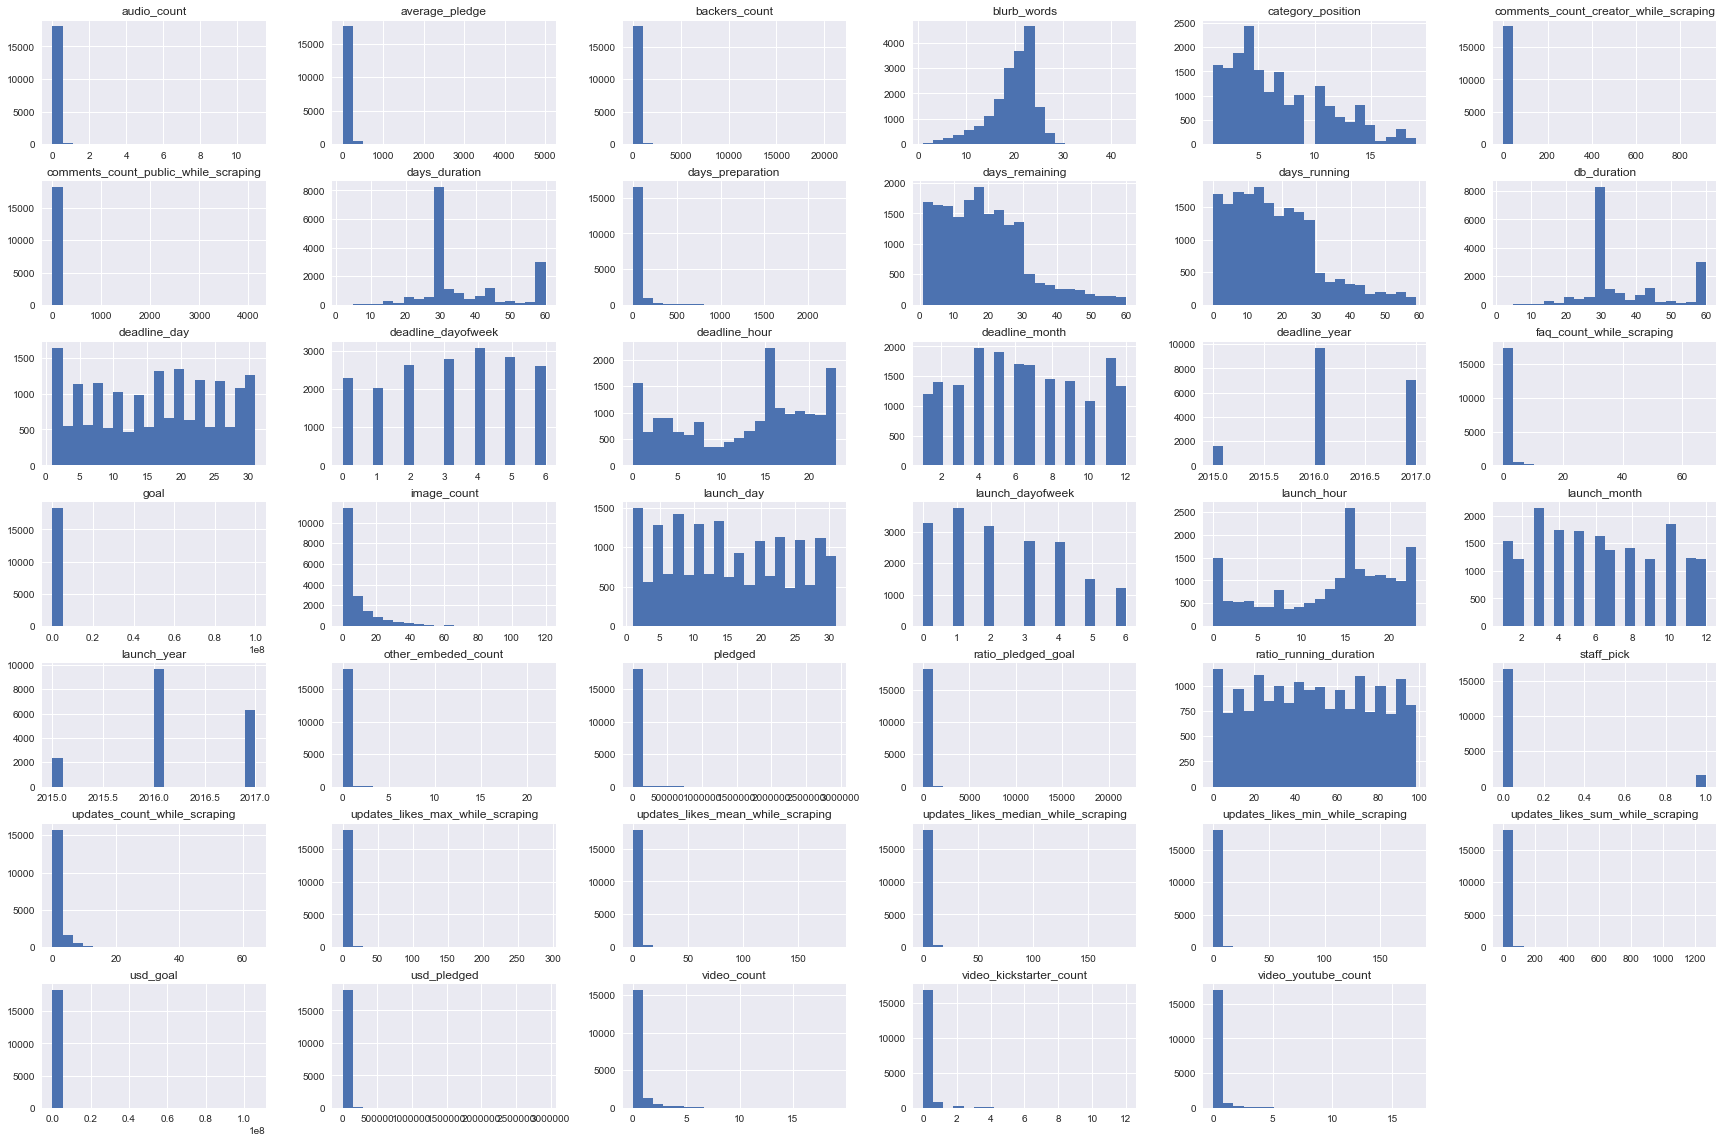

In [33]:
# original data
df[numeric_features].hist(bins=20, figsize=[30, 20])

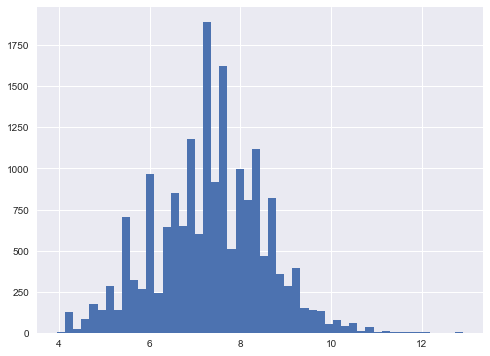

In [53]:
# from sklearn.preprocessing import PowerTransformer dev only
# use scipy boxcox instead
plt.rcParams['figure.figsize'] = [8, 6]
goal_boxcox, l = boxcox(x=df['goal'])
pom = pd.Series(goal_boxcox).hist(bins=50)

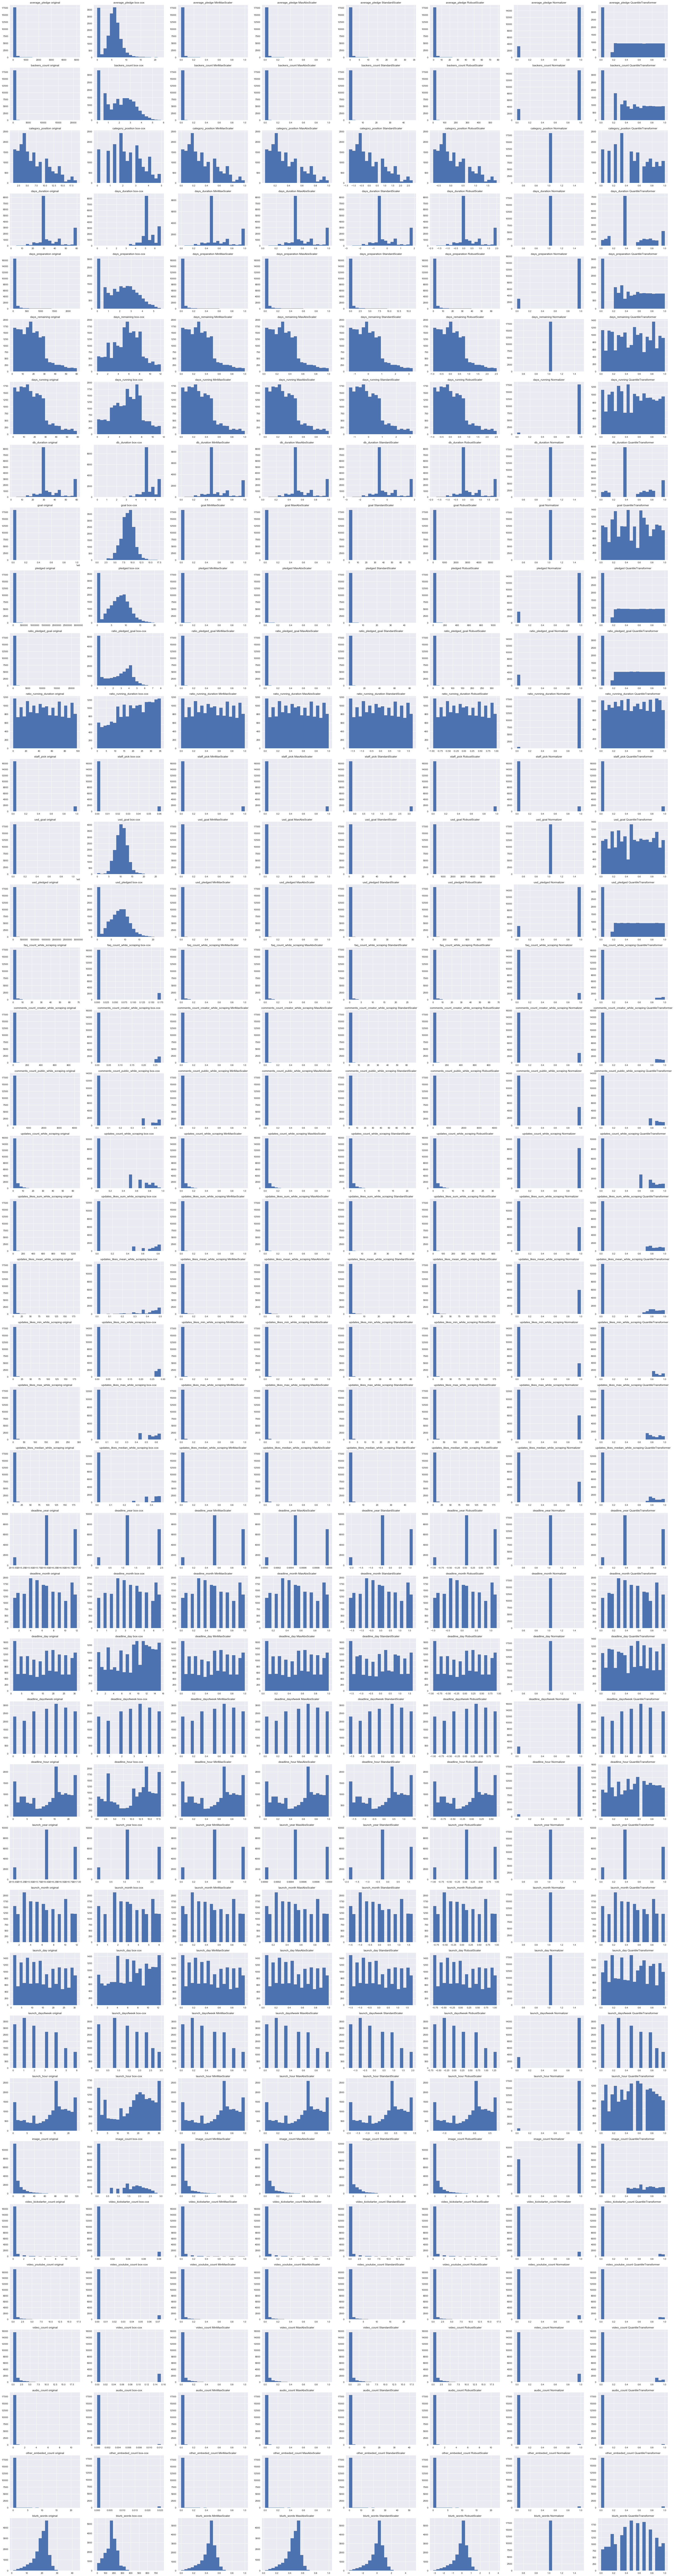

In [35]:
# let's discover how different scalers affect distribution

plt.rcParams['figure.figsize'] = [50, 200]
fig, ax = plt.subplots(len(numeric_features), 8)

for col, i in zip(numeric_features, range(len(numeric_features))) :
    ax[i, 0].hist(df[col], bins=20)
    ax[i, 0].set_title(col + ' original')
    
    # box-cox only works for positive values
    # also problems occur when the lowest value of attribute is higher
    # we fixed both problems by shifting values the way that the lowest value of each attribute is equal 1
    tmp, att = boxcox(df[col] - df[col].min() + 1)
    ax[i, 1].hist(pd.Series(tmp), bins=20)
    ax[i, 1].set_title(col + ' box-cox')
    
    ax[i, 2].hist(MinMaxScaler().fit_transform(df[[col]]), bins=20)
    ax[i, 2].set_title(col + ' MinMaxScaler')
    
    ax[i, 3].hist(MaxAbsScaler().fit_transform(df[[col]]), bins=20)
    ax[i, 3].set_title(col + ' MaxAbsScaler')
    
    ax[i, 4].hist(StandardScaler().fit_transform(df[[col]]), bins=20)
    ax[i, 4].set_title(col + ' StandardScaler')
    
    ax[i, 5].hist(RobustScaler().fit_transform(df[[col]]), bins=20)
    ax[i, 5].set_title(col + ' RobustScaler')
    
    ax[i, 6].hist(Normalizer().fit_transform(df[[col]]), bins=20)
    ax[i, 6].set_title(col + ' Normalizer')
    
    ax[i, 7].hist(QuantileTransformer().fit_transform(df[[col]]), bins=20)
    ax[i, 7].set_title(col + ' QuantileTransformer')
    
fig.savefig('scalers.pdf')

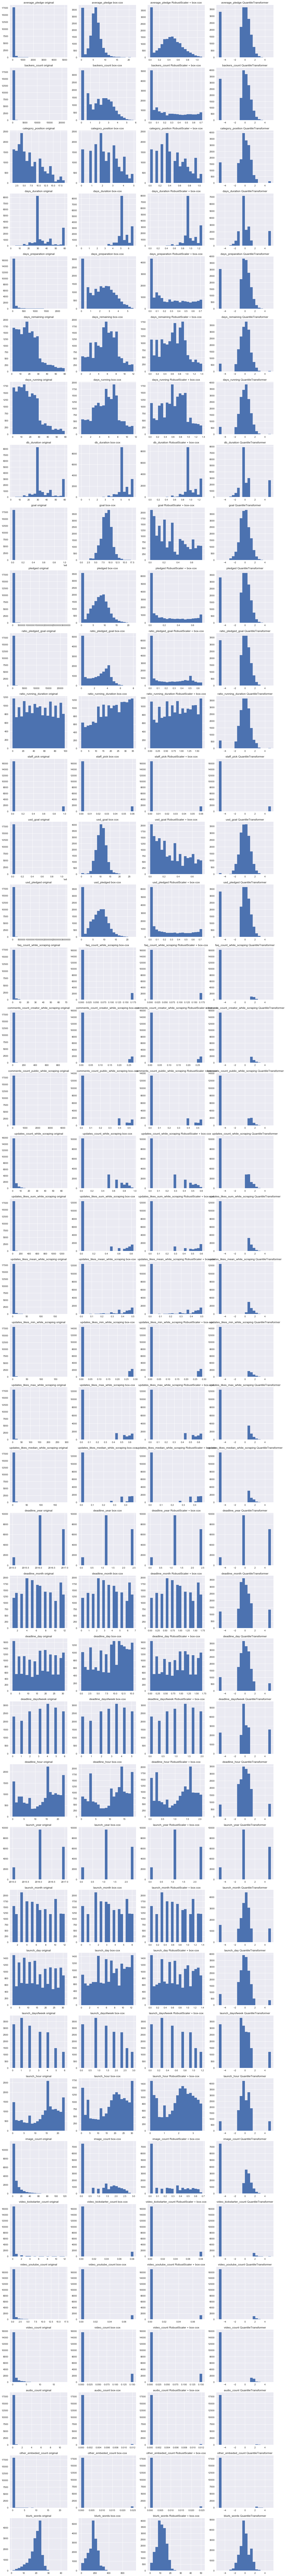

In [36]:
# let's select some transformers and see how they affect accuracy of models
df_boxcox = pd.DataFrame()
df_robustscaler_boxcox = pd.DataFrame()
df_quantiletransformer = pd.DataFrame()

plt.rcParams['figure.figsize'] = [20, 200]
fig, ax = plt.subplots(len(numeric_features), 4)

for col, i in zip(numeric_features, range(len(numeric_features))) :
    ax[i, 0].hist(df[col], bins=20)
    ax[i, 0].set_title(col + ' original')
    
    # box-cox only works for positive values
    # also problems occur when the lowest value of attribute is higher
    # we fixed both problems by shifting values the way that the lowest value of each attribute is equal 1
    tmp, att = boxcox(df[col] - df[col].min() + 1)
    df_boxcox[col] = pd.Series(tmp)
    ax[i, 1].hist(df_boxcox[col], bins=20)
    ax[i, 1].set_title(col + ' box-cox')
    
    tmp2 = pd.DataFrame(RobustScaler().fit_transform(df[[col]]))[0]
    tmp, att = boxcox(tmp2 - tmp2.min() + 1)
    df_robustscaler_boxcox[col] = pd.Series(tmp)
    ax[i, 2].hist(df_robustscaler_boxcox[col], bins=20)
    ax[i, 2].set_title(col + ' RobustScaler + box-cox')
    
    df_quantiletransformer[col] = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(df[[col]]))[0]
    ax[i, 3].hist(df_quantiletransformer[col], bins=20)
    ax[i, 3].set_title(col + ' QuantileTransformer')

fig.savefig('scalers2.pdf')

In [23]:
df.reset_index(inplace=True)

In [24]:
df_boxcox['class'] = df['class']
df_robustscaler_boxcox['class'] = df['class']
df_quantiletransformer['class'] = df['class']

In [25]:
df_boxcox['ratio_running_duration_original'] = df['ratio_running_duration']
df_robustscaler_boxcox['ratio_running_duration_original'] = df['ratio_running_duration']
df_quantiletransformer['ratio_running_duration_original'] = df['ratio_running_duration']

In [27]:
df_boxcox.to_csv('data/normalized/boxcox.csv')
df_robustscaler_boxcox.to_csv('data/normalized/robustscaler_boxcox.csv')
df_quantiletransformer.to_csv('data/quantiletransformer.csv')

We tested above transformations on all multiclass classifiers provided by scikit-learn and found out that the best results (depending on used classifier) are reached with:
* data that were transformed using RobustScaler followed by Box-Cox normalization
* original data

### Now use the best solution (RobustScaler + Box-Cox)

In [79]:
df = pd.read_csv('data/split/train.csv', encoding='latin1', index_col=0)
df_test = pd.read_csv('data/split/test.csv', encoding='latin1', index_col=0)
df_cv = pd.read_csv('data/split/cv.csv', encoding='latin1', index_col=0)

In [80]:
df_transformed = pd.DataFrame()
df_test_transformed = pd.DataFrame()
df_cv_transformed = pd.DataFrame()

for col, i in zip(numeric_features, range(len(numeric_features))) :
    scaler = RobustScaler()
    
    # fit on train set
    
    scaler.fit(df[[col]]) # fit scaler on train
    scaled = pd.DataFrame(scaler.transform(df[[col]]))[0]
    
    normalized, lam = boxcox(scaled - scaled.min() + 1) # fit box-cox on train
    df_transformed[col] = pd.Series(normalized)
    
    # now use model values to transform test and cv sets
    
    scaled = pd.DataFrame(scaler.transform(df_test[[col]]))[0]
    normalized = boxcox(scaled - scaled.min() + 1, lmbda=lam)
    df_test_transformed[col] = pd.Series(normalized)
    
    scaled = pd.DataFrame(scaler.transform(df_cv[[col]]))[0]
    normalized = boxcox(scaled - scaled.min() + 1, lmbda=lam)
    df_cv_transformed[col] = pd.Series(normalized)

In [81]:
df_transformed.describe()

,average_pledge,backers_count,category_position,days_duration,days_preparation,days_remaining,days_running,db_duration,goal,pledged,...,launch_day,launch_dayofweek,launch_hour,image_count,video_kickstarter_count,video_youtube_count,video_count,audio_count,other_embeded_count,blurb_words
count,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,...,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000,18296.000000
mean,0.379985,0.249142,0.482924,0.990039,0.264500,0.628901,0.619286,0.988685,0.293156,0.240163,...,0.707228,0.557812,1.889546,0.230486,0.006813,0.005297,0.021837,0.000160,0.000691,11.064225
std,0.265886,0.233315,0.286353,0.173828,0.231762,0.335893,0.329980,0.172962,0.221053,0.250219,...,0.411378,0.372617,1.091191,0.228987,0.022657,0.018971,0.053453,0.001389,0.004116,4.436958
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.164080,0.025510,0.242085,0.913308,0.053501,0.379737,0.376302,0.911329,0.095020,0.008961,...,0.345006,0.293946,0.926679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.175641
50%,0.395524,0.183912,0.497721,0.913308,0.212505,0.645896,0.635928,0.911329,0.236786,0.139327,...,0.691810,0.530799,2.044111,0.219017,0.000000,0.000000,0.000000,0.000000,0.000000,11.114805
75%,0.566492,0.448964,0.732243,1.127745,0.457602,0.872313,0.854085,1.124654,0.472278,0.450859,...,1.080414,0.903191,2.803085,0.440960,0.000000,0.000000,0.000000,0.000000,0.000000,14.549481
max,1.108198,0.715851,1.058317,1.280894,0.725325,1.410773,1.362795,1.276833,0.749780,0.736329,...,1.388310,1.193791,3.646269,0.685480,0.082173,0.073249,0.153568,0.012207,0.025218,51.252734


In [82]:
df_test_transformed.describe()

,average_pledge,backers_count,category_position,days_duration,days_preparation,days_remaining,days_running,db_duration,goal,pledged,...,launch_day,launch_dayofweek,launch_hour,image_count,video_kickstarter_count,video_youtube_count,video_count,audio_count,other_embeded_count,blurb_words
count,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,...,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000
mean,0.374420,0.247161,0.482816,0.941620,0.261108,0.630750,0.619635,0.940545,0.286938,0.238682,...,0.700926,0.564432,1.889232,0.228127,0.007019,0.005548,0.022497,0.000166,0.000715,11.043197
std,0.267059,0.234434,0.286640,0.190228,0.230298,0.334675,0.330448,0.189109,0.218687,0.250273,...,0.415338,0.371214,1.097836,0.227200,0.022967,0.019382,0.054111,0.001414,0.004187,4.495541
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.137351,0.025510,0.242085,0.858758,0.053501,0.379737,0.376302,0.857019,0.093967,0.007184,...,0.345006,0.293946,0.926679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.175641
50%,0.388434,0.167687,0.497721,0.858758,0.196347,0.645896,0.635928,0.857019,0.221408,0.141084,...,0.691810,0.530799,2.044111,0.219017,0.000000,0.000000,0.000000,0.000000,0.000000,11.114805
75%,0.561557,0.446504,0.732243,1.090974,0.446944,0.872313,0.854085,1.088093,0.472043,0.450527,...,1.080414,0.903191,2.803085,0.440960,0.000000,0.000000,0.000000,0.000000,0.000000,14.549481
max,1.108468,0.715529,1.058317,1.253677,0.724455,1.410773,1.362795,1.249800,0.749780,0.736301,...,1.388310,1.193791,3.646269,0.693539,0.082173,0.073249,0.153568,0.012207,0.025218,70.229757


In [83]:
df_cv_transformed.describe()

,average_pledge,backers_count,category_position,days_duration,days_preparation,days_remaining,days_running,db_duration,goal,pledged,...,launch_day,launch_dayofweek,launch_hour,image_count,video_kickstarter_count,video_youtube_count,video_count,audio_count,other_embeded_count,blurb_words
count,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,...,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000
mean,0.373750,0.246669,0.476263,0.962406,0.261225,0.635638,0.619266,0.961402,0.290638,0.235094,...,0.705590,0.557132,1.888107,0.226670,0.006425,0.005307,0.021146,0.000154,0.000542,10.932469
std,0.265872,0.234539,0.288857,0.186235,0.230806,0.340455,0.333495,0.185138,0.224052,0.248816,...,0.407917,0.373110,1.095519,0.227428,0.022061,0.018990,0.052738,0.001363,0.003656,4.509059
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.151459,0.025510,0.242085,0.877506,0.053501,0.379737,0.376302,0.875687,0.093967,0.007184,...,0.345006,0.293946,0.926679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.175641
50%,0.383988,0.167687,0.422713,0.877506,0.212505,0.645896,0.635928,0.875687,0.236099,0.135403,...,0.691810,0.530799,2.044111,0.219017,0.000000,0.000000,0.000000,0.000000,0.000000,11.114805
75%,0.560147,0.445274,0.732243,1.103510,0.457602,0.872313,0.875012,1.100558,0.472043,0.440324,...,1.039712,0.903191,2.803085,0.421084,0.000000,0.000000,0.000000,0.000000,0.000000,14.549481
max,1.082706,0.715556,1.058317,1.262912,0.724689,1.410773,1.362795,1.258973,0.749780,0.736289,...,1.388310,1.193791,3.646269,0.679289,0.082173,0.073249,0.153568,0.012207,0.025218,26.256559


In [84]:
# add class column to transformed data
col = 'class'
df_transformed[col] = df[col]
df_test_transformed[col] = df_test[col]
df_cv_transformed[col] = df_cv[col]

In [86]:
# add ratio_running_duration column to transformed data (to be able to correctly separate data for different models)
col = 'ratio_running_duration_original'
col2 = 'ratio_running_duration'
df_transformed[col] = df[col2]
df_test_transformed[col] = df_test[col2]
df_cv_transformed[col] = df_cv[col2]

In [87]:
df_transformed.to_csv('data/split/transformed/train.csv')
df_test_transformed.to_csv('data/split/transformed/test.csv')
df_cv_transformed.to_csv('data/split/transformed/cv.csv')

In [93]:
df_transformed.shape

(18296, 43)

### Keep original

In [95]:
df[numeric_features + ['class']].to_csv('data/split/transformed/train_original.csv')
df_test[numeric_features + ['class']].to_csv('data/split/transformed/test_original.csv')
df_cv[numeric_features + ['class']].to_csv('data/split/transformed/cv_original.csv')

# TODO

### 3. Encoding categorical features

In [4]:
df.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30691 entries, 0 to 30701
Data columns (total 9 columns):
category_name          30691 non-null object
category_parent        30691 non-null object
country                30691 non-null object
currency               30691 non-null object
db_description_full    30691 non-null object
location_name          30691 non-null object
location_state         30691 non-null object
location_type          30691 non-null object
url_name               30691 non-null object
dtypes: object(9)
memory usage: 2.3+ MB


In [231]:
# 'category_name' - too many unique values - category_parent is discretized category_name
# db_description_full - each is unique
# 'location_name' - too many unique values
# 'location_state' - too many unique values - country is discretized state
data_to_encode = [
    'category_parent',
    'country',
    'currency',
    'location_type',
    'staff_pick'
]
encoded = []

#### 1st option - use encoders

In [232]:
# encode only attributes with less than 25 distinct values
for column in data_to_encode:
    print(column, df[column].nunique(), 'unique values')
    encoder = ce.OrdinalEncoder()
    df[column+'_num'] = encoder.fit_transform(df[[column]])
    encoded.append(column+'_num')

category_parent 15 unique values
country 22 unique values
currency 14 unique values
location_type 9 unique values
staff_pick 3 unique values


In [233]:
df[encoded].describe()

,category_parent_num,country_num,currency_num,location_type_num,staff_pick_num
count,30691.000000,30691.000000,30691.000000,30691.000000,30691.000000
mean,7.352383,2.273826,1.174644,0.240201,0.972500
std,3.909426,4.334178,2.340875,0.876938,0.448987
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,1.000000
50%,8.000000,0.000000,0.000000,0.000000,1.000000
75%,11.000000,3.000000,1.000000,0.000000,1.000000
max,14.000000,21.000000,13.000000,8.000000,2.000000


In [234]:
enc = preprocessing.OneHotEncoder()
enc.fit(df[encoded])

# count of distinct values per each column
enc.n_values_

array([15, 22, 14,  9,  3])

In [235]:
# index borders
enc.feature_indices_

array([ 0, 15, 37, 51, 60, 63], dtype=int32)

In [236]:
df_encoded_categorical = pd.DataFrame(enc.transform(df[encoded]).toarray())
df_encoded_categorical.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### 2nd option - get_dummies

In [237]:
pd.get_dummies(df[data_to_encode]).head()

,category_parent_art,category_parent_comics,category_parent_crafts,category_parent_dance,category_parent_design,category_parent_fashion,category_parent_film & video,category_parent_food,category_parent_games,category_parent_journalism,...,location_type_Estate,location_type_Island,location_type_LocalAdmin,location_type_Miscellaneous,location_type_Suburb,location_type_Town,location_type_Zip,staff_pick_False,staff_pick_True,staff_pick_Unknown
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


## Feature selection

In [ ]:
# change index types
df_encoded_categorical.index = df_encoded_categorical.index.astype('int64')
df_static.index = df_static.index.astype('int64')

In [ ]:
df_static = df_static.join(df_encoded_categorical)

In [ ]:
df_static.to_csv('data/static_02_no_categorical.csv')